In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Text
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# Capture similarity 
from sentence_transformers import SentenceTransformer



In [43]:
%%time
stocks = pd.read_csv('sp500.csv')

CPU times: total: 15.6 ms
Wall time: 12.8 ms


In [44]:
print(stocks.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   idnumber             493 non-null    int64  
 1   exchange             493 non-null    object 
 2   symbol               493 non-null    object 
 3   shortname            493 non-null    object 
 4   longname             493 non-null    object 
 5   longnamesort         493 non-null    object 
 6   sector               493 non-null    object 
 7   industry             493 non-null    object 
 8   prices               493 non-null    float64
 9   marketcap            493 non-null    float64
 10  ebitda               463 non-null    float64
 11  revenuegrowth        492 non-null    float64
 12  city                 493 non-null    object 
 13  state                474 non-null    object 
 14  country              493 non-null    object 
 15  fulltimeemployees    486 non-null    flo

In [45]:
stocks.drop(['longnamesort','prices','esgrating','logo'], inplace=True, axis=1)

In [46]:
print(stocks.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   idnumber             493 non-null    int64  
 1   exchange             493 non-null    object 
 2   symbol               493 non-null    object 
 3   shortname            493 non-null    object 
 4   longname             493 non-null    object 
 5   sector               493 non-null    object 
 6   industry             493 non-null    object 
 7   marketcap            493 non-null    float64
 8   ebitda               463 non-null    float64
 9   revenuegrowth        492 non-null    float64
 10  city                 493 non-null    object 
 11  state                474 non-null    object 
 12  country              493 non-null    object 
 13  fulltimeemployees    486 non-null    float64
 14  longbusinesssummary  493 non-null    object 
 15  weight               493 non-null    flo

Sector Distribution

<AxesSubplot:>

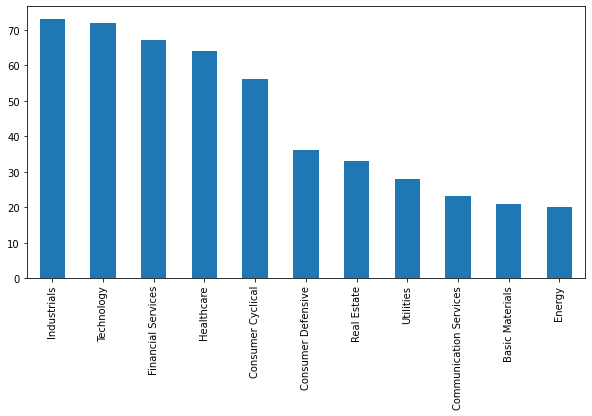

In [47]:
stocks['sector'].value_counts().plot(x = 'sector', y ='count', kind = 'bar', figsize = (10,5))

Industry Distribution

<AxesSubplot:>

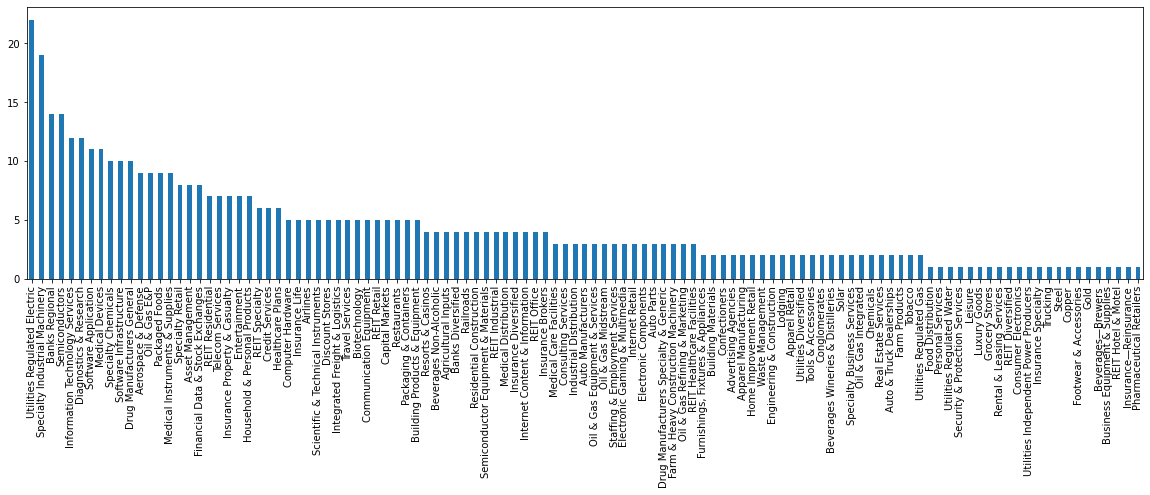

In [48]:
stocks['industry'].value_counts().plot(x = 'industry', y ='count', kind = 'bar', figsize = (20,5))

Exchange Distribution

<AxesSubplot:>

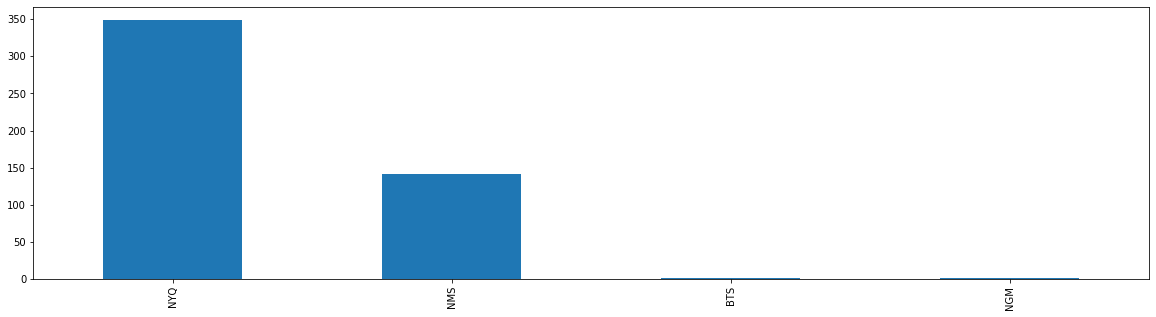

In [49]:
stocks['exchange'].value_counts().plot(x = 'exchange', y ='count', kind = 'bar', figsize = (20,5))

In [50]:
X = np.array(stocks.longbusinesssummary)

In [51]:
text_data = X
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(text_data, show_progress_bar=True)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [52]:
embed_data = embeddings

In [53]:
X = np.array(embed_data)
n_comp = 5
pca = PCA(n_components=n_comp)
pca.fit(X)
pca_data = pd.DataFrame(pca.transform(X))
pca_data.head()

,0,1,2,3,4
0,-1.094552,-3.025231,1.445607,-0.679007,-0.555004
1,-1.318475,-1.289032,-2.584338,-1.628607,3.127817
2,-2.478820,-1.561217,-4.145492,-0.558129,2.921854
3,-2.174773,-1.666620,-3.896385,0.295148,3.529506
4,-4.333914,0.252663,2.797528,1.588046,1.798626


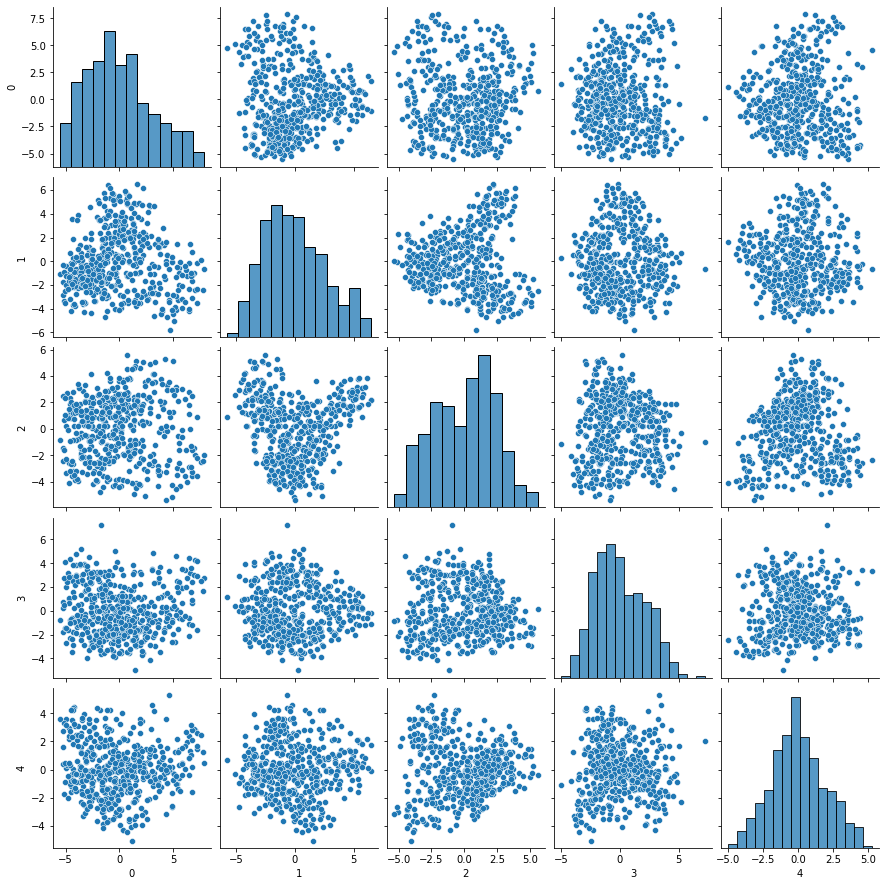

In [54]:
sns.pairplot(pca_data)

Recommender function taken in modified form from:https://towardsdatascience.com/hands-on-content-based-recommender-system-using-python-1d643bf314e4

In [55]:
cos_sim_data = pd.DataFrame(cosine_similarity(X))


def give_recommendations(index, print_recommendation=False, print_recommendation_plots=False, print_genres=False):
    index_recomm = cos_sim_data.loc[index].sort_values(
        ascending=False).index.tolist()[1:21]
    stocks_recomm = stocks['symbol'].loc[index_recomm].values
    result = {'Stocks': stocks_recomm, 'Index': index_recomm}
    if print_recommendation == True:
        print('The watched stock is this one: %s \n' %(stocks['symbol'].loc[index]))
        k = 1
        for stock in stocks_recomm:
            print('The number %i recommended stock is this one: %s \n' %(k, stock))
    if print_recommendation_plots == True:
        print('The longbusinesssummary of the watched stock is this one:\n %s \n' %(stocks['longbusinesssummary'].loc[index]))
        k = 1
        for q in range(len(stocks_recomm)):
            plot_q = stocks['longbusinesssummary'].loc[index_recomm[q]]
            print('The longbusinesssummary of the number %i recommended stock is this one:\n %s \n' % (
                k, plot_q))
            k = k+1
    if print_genres == True:
        print('The sector of the watched stock is this one:\n %s \n' %
              (stocks['sector'].loc[index]))
        k = 1
        for q in range(len(stocks_recomm)):
            plot_q = stocks['sector'].loc[index_recomm[q]]
            print('The sector of the number %i recommended stock is this one:\n %s \n' % (
                k, plot_q))
            k = k+1
    return result

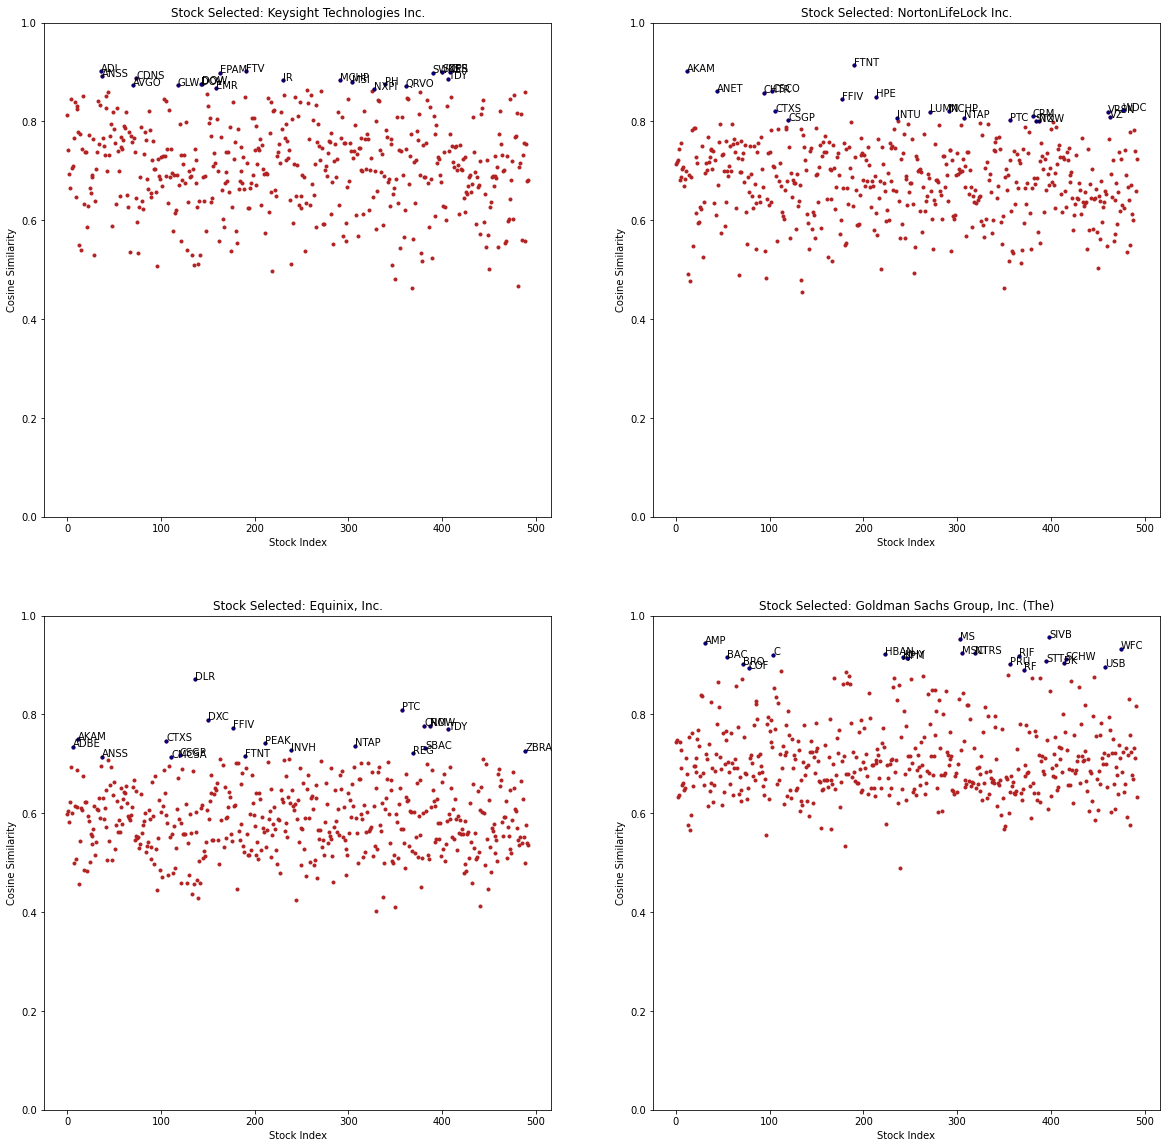

In [56]:
plt.figure(figsize=(20,20))
for q in range(1,5):
  plt.subplot(2,2,q)
  index = np.random.choice(np.arange(0,len(X)))
  to_plot_data = cos_sim_data.drop(index,axis=1)
  plt.plot(to_plot_data.loc[index],'.',color='firebrick')
  recomm_index = give_recommendations(index)
  x = recomm_index['Index']
  y = cos_sim_data.loc[index][x].tolist()
  m = recomm_index['Stocks']
  plt.plot(x,y,'.',color='navy',label='Recommended Stocks')
  plt.title('Stock Selected: '+stocks['shortname'].loc[index])
  plt.xlabel('Stock Index')
  k=0
  for x_i in x:
    plt.annotate('%s'%(m[k]),(x_i,y[k]),fontsize=10)
    k=k+1

  plt.ylabel('Cosine Similarity')
  plt.ylim(0,1)

In [57]:
# give_recommendations(95,True, True, True)

Record recommendation results into Pandas DF

In [58]:
recomm_list = []
for i in range(len(X)):
    recomm_i = give_recommendations(i)
    recomm_list.append(recomm_i['Stocks'])
recomm_data = pd.DataFrame(recomm_list, columns=['1', '2', '3', '4', '5', ' 6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'])
recomm_data['Target'] = stocks['symbol']
recomm_data = recomm_data[['Target', '1', '2', '3', '4', '5', ' 6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']]


In [59]:
# recommend_list = []
# for i in range(0,493):
#   print("Stock Number:", i)
#   print(give_recommendations(i, True, True, True))
#   print("-"*40)

#   recomm_i = give_recommendations(i, True, True, True)
#   recomm_list.append(recomm_i['Stocks'])
# recomm_data2 = pd.DataFrame(recomm_list, columns=['First Recommendation', 'Second Recommendation', 'Third Recommendation', 'Fourth Recommendation', 'Fifth Recommendation', ' Sixth Recommendation', 'Seventh Recommendation', 'Eighth Recommendation', 'Ninth Recommendation', 'Tenth Recommendation'])
# recomm_data2['Watched Stock'] = stocks['symbol']
# recomm_data2 = recomm_data2[['Watched Stock', 'First Recommendation', 'Second Recommendation','Third Recommendation', 'Fourth Recommendation', 'Fifth Recommendation', ' Sixth Recommendation', 'Seventh Recommendation', 'Eighth Recommendation', 'Ninth Recommendation', 'Tenth Recommendation']]

# recomm_data2.sample(frac=1).head()

In [60]:
recomm_data.sample(frac=1).head()

,Target,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
471,WMT,AMZN,KR,HSY,TGT,COST,SJM,FBHS,EXPE,GPN,...,CPRT,WBA,ICE,YUM,MGM,F,COF,MNST,CDW,CAG
240,IQV,VRSK,EFX,DHR,GPN,MSFT,RHI,LDOS,TEL,IT,...,BSX,IEX,HPQ,TYL,CTSH,DD,DXC,J,XYL,APH
9,AFL,CI,GL,HUM,CVS,OGN,MET,L,MRK,CAH,...,HCA,PFE,COO,CNC,AIZ,CINF,BAX,CL,WST,UNH
41,AMAT,DD,KLAC,APH,AVGO,TER,SWKS,LRCX,TEL,DHR,...,HPQ,ON,NXPI,GLW,ALB,TXN,ROK,MPWR,ADI,KEYS
181,FDX,ODFL,ROST,TGT,AAL,ZION,CHRW,EXR,LNC,ATO,...,DAL,PSA,FITB,WFC,UPS,UAL,CAG,AMP,INTU,MOH


In [61]:
recomm_data.to_csv("cosine_sim.csv", encoding='utf-8', index=False)